## LangGraph RAG (Retrieval-Augmented Generation) Tutorial

This notebook demonstrates building a RAG system using LangGraph with Hugging Face models. **RAG** combines the power of large language models with external knowledge retrieval to provide accurate, up-to-date responses.

### Key Concepts:
- **Retrieval**: Finding relevant documents from a knowledge base
- **Augmentation**: Enhancing LLM prompts with retrieved context
- **Generation**: Producing responses based on both training data and retrieved information
- **Vector Store**: Database optimized for semantic similarity search

### What You'll Build:
A complete RAG pipeline that loads web content, creates embeddings, and answers questions using retrieved context.

## Environment Setup for RAG

Install packages for building a complete RAG system:
- **langchain-huggingface**: Interface to Hugging Face models and embeddings
- **transformers & torch**: Core ML libraries for running models locally
- **langgraph**: Orchestration framework for complex AI workflows

In [1]:
!pip install -q langchain langchain-core langchain_community langgraph langchain-huggingface transformers torch unstructured

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.9 MB/s eta 0:00:00
   ━━━━━━

In [9]:
!pip install -q langchain_chroma langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 3.1 MB/s eta 0:00:00


## Document Loading

Load content from web URLs using UnstructuredURLLoader [(Docs)](https://python.langchain.com/docs/integrations/document_loaders/). This extracts text from web pages and converts them into LangChain Document objects for processing.

In [3]:
from langchain_community.document_loaders import UnstructuredURLLoader

# Load LangGraph documentation for our knowledge base
# UnstructuredURLLoader extracts and parses text content from web pages
# urls = ['https://langchain-ai.github.io/langgraph/tutorials/introduction/'] <--- Redirected to:
urls = ['https://langchain-ai.github.io/langgraph/concepts/why-langgraph/',
        'https://langchain-ai.github.io/langgraph/tutorials/get-started/1-build-basic-chatbot/',
        'https://langchain-ai.github.io/langgraph/tutorials/get-started/2-add-tools/',
        'https://langchain-ai.github.io/langgraph/tutorials/get-started/3-add-memory/',
        'https://langchain-ai.github.io/langgraph/tutorials/get-started/4-human-in-the-loop/',
        'https://langchain-ai.github.io/langgraph/tutorials/get-started/5-customize-state/',
        'https://langchain-ai.github.io/langgraph/tutorials/get-started/6-time-travel/',
        ]
loader = UnstructuredURLLoader(urls=urls)
docs = loader.load()

In [4]:
docs

[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/concepts/why-langgraph/'}, page_content="Overview¶\n\nLangGraph is built for developers who want to build powerful, adaptable AI agents. Developers choose LangGraph for:\n\nReliability and controllability. Steer agent actions with moderation checks and human-in-the-loop approvals. LangGraph persists context for long-running workflows, keeping your agents on course.\n\nLow-level and extensible. Build custom agents with fully descriptive, low-level primitives free from rigid abstractions that limit customization. Design scalable multi-agent systems, with each agent serving a specific role tailored to your use case.\n\nFirst-class streaming support. With token-by-token streaming and streaming of intermediate steps, LangGraph gives users clear visibility into agent reasoning and actions as they unfold in real time.\n\nLearn LangGraph basics¶\n\nTo get acquainted with LangGraph's key concepts and features, complete the 

## Text Chunking Strategy

**Why split documents?** Large documents exceed model context limits and reduce retrieval precision. Chunking creates manageable pieces while preserving context:

- **chunk_size=1000**: Optimal balance between context and efficiency
- **chunk_overlap=200**: Prevents information loss at boundaries  
- **RecursiveCharacterTextSplitter**: Intelligently splits at natural boundaries (paragraphs, sentences)

## Text Chunking

Split documents into manageable chunks for embedding and retrieval. Proper chunking ensures each piece contains coherent information while maintaining context overlap.

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

print("Total number of documents: ",len(all_splits))

Total number of documents:  116


In [6]:
all_splits[7]

Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/get-started/1-build-basic-chatbot/'}, page_content='# The first argument is the unique node name\n# The second argument is the function or object that will be called whenever\n# the node is used.\ngraph_builder.add_node("chatbot", chatbot)\n\nNotice how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". This is the basic pattern for all LangGraph node functions.\n\nThe add_messages function in our State will append the LLM\'s response messages to whatever messages are already in the state.\n\n4. Add an entry point¶\n\nAdd an entry point to tell the graph where to start its work each time it is run:\n\ngraph_builder.add_edge(START, "chatbot")\n\n5. Add an exit point¶\n\nAdd an exit point to indicate where the graph should finish execution. This is helpful for more complex flows, but even in a simple graph like thi

## Embeddings: Converting Text to Vectors

**Embeddings** transform text into numerical vectors that capture semantic meaning. Similar concepts cluster together in vector space, enabling semantic search:

- **HuggingFaceEmbeddings**: Uses pre-trained models for text encoding
- **Vector dimensions**: Each text chunk becomes a high-dimensional vector
- **Semantic similarity**: Distance between vectors indicates conceptual relationship

Embedding models: https://python.langchain.com/v0.1/docs/integrations/text_embedding/

In [7]:
# Let's load the Hugging Face Embedding class.  sentence_transformers
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings()

vector = embeddings.embed_query("hello, world!")
vector[:5]

/tmp/ipython-input-729653346.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings()
/tmp/ipython-input-729653346.py:3: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggin

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[0.03492268547415733,
 0.0188300758600235,
 -0.017854738980531693,
 0.0001388332893839106,
 0.07407363504171371]

## Vector Store: Building the Knowledge Base

**ChromaDB** creates a searchable database for document embeddings:

- **from_documents()**: Automatically embeds and indexes all document chunks
- **Similarity search**: Finds most relevant chunks based on query vectors
- **Persistence**: Optionally save the database locally to avoid recomputing embeddings

The vector store is the foundation of retrieval - it makes semantic search possible.

In [8]:
from langchain_chroma import Chroma
from langchain_core.documents import Document

vectorstore = Chroma.from_documents(documents=all_splits, embedding=embeddings)

# if you want to store chromadb locally

# vectorstore = Chroma.from_documents(
#     documents=docs,
#     embedding=HuggingFaceEmbeddings(),
#     persist_directory="./my_chroma_db"  # Custom directory
# )


# Loading the Database Later
# This reloads the previously stored embeddings so you don’t have to recompute them.

# vectorstore = Chroma(
#     persist_directory="./my_chroma_db",
#     embedding_function=HuggingFaceEmbeddings()
# )

## Local LLM Setup: Hugging Face Pipeline

Using **local models** provides privacy and cost control compared to API-based solutions:

- **falcon-7b**: Efficient open-source model suitable for RAG tasks
- **torch_dtype=bfloat16**: Memory-optimized precision for faster inference
- **max_new_tokens=200**: Limits response length for efficiency
- **Temperature & top_k**: Controls response creativity and diversity

Local models require GPU memory but eliminate API costs and latency.

In [19]:
# from langchain_huggingface import HuggingFacePipeline
# from langchain.prompts import PromptTemplate
# from transformers import pipeline
# from langchain_core.output_parsers import StrOutputParser
# import torch
# from transformers import AutoModelForCausalLM, AutoTokenizer

# #model_id = "meta-llama/Meta-Llama-3-8B"
# model_id = "tiiuae/falcon-7b"

# # text_generation_pipeline = pipeline(
# #     "text-generation", model=model_id, model_kwargs={"torch_dtype": torch.bfloat16}, max_new_tokens=400, device=0)

# text_generation_pipeline = pipeline(
#     "text-generation",
#     model=model_id,
#     model_kwargs={"torch_dtype": torch.bfloat16},
#     max_new_tokens=200,
#     device=0,
#     temperature=0.7,  #  (lower values = more deterministic)
#     top_k=50,  # Filters out low-probability tokens
# )

# llm = HuggingFacePipeline(pipeline=text_generation_pipeline)




In [11]:
from langchain_openai import ChatOpenAI
from google.colab import userdata
llm = ChatOpenAI(temperature=0.3, model="gpt-4.1-nano", api_key=userdata.get('OPENAI_API_KEY'))

## RAG Prompt Template

**Prompt engineering** is crucial for RAG success. The prompt template structures how retrieved context is presented to the LLM:

- **Context injection**: Places relevant documents before the question
- **Instructions**: Guides the model on how to use the context
- **Constraints**: Prevents hallucination by limiting responses to provided context
- **Hub.pull()**: Uses community-tested prompts for better results

In [12]:
# from langchain_core.prompts import PromptTemplate

# template = """Use the following pieces of context to answer the question at the end.
# If you don't know the answer, just say that you don't know, don't try to make up an answer.
# Use three sentences maximum and keep the answer as concise as possible.
# Always say "thanks for asking!" at the end of the answer.

# {context}

# Question: {question}

# Helpful Answer:"""
# prompt = PromptTemplate.from_template(template)


from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
prompt

/usr/local/lib/python3.12/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

## LangGraph State Management

**State** defines the data structure that flows through the RAG workflow. TypedDict provides type safety and clear contracts:

- **question**: User's input query
- **context**: Retrieved documents from vector store
- **answer**: Final LLM response

State management ensures data consistency and enables complex multi-step workflows.

In [13]:
from typing_extensions import List, TypedDict

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


## Step 1: Retrieval Function

The **retrieval step** finds relevant documents based on semantic similarity:

- **similarity_search()**: Queries vector store with the user's question
- **k=1**: Retrieves top 1 most relevant document (adjust based on context window)
- **State update**: Adds retrieved documents to the workflow state

This step transforms user questions into relevant knowledge context.

In [14]:
# Define application steps
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"],  k=1)
    return {"context": retrieved_docs}



## Step 2: Generation Function

The **generation step** combines retrieved context with the user's question to produce an informed response:

- **Document concatenation**: Joins retrieved content into coherent context
- **Prompt invocation**: Structures the context and question using the RAG template
- **LLM inference**: Generates response based on both training data and retrieved context

This step completes the RAG pipeline by grounding the LLM's response in retrieved knowledge.

In [15]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    #return {"answer": response.content}
    return {"answer": response}



## Workflow Compilation: Building the RAG Graph

**LangGraph orchestration** connects retrieval and generation into a seamless pipeline:

- **StateGraph**: Defines the workflow structure with typed state
- **add_sequence()**: Creates linear flow: retrieve → generate
- **Compilation**: Optimizes the graph for execution
- **START edge**: Defines the entry point (retrieve step)

The graph ensures proper data flow and error handling between steps.

In [16]:
from langgraph.graph import START, StateGraph

# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

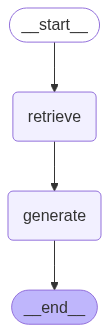

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Testing the Complete RAG System

Execute the full RAG pipeline with a question about LangGraph. The system will:
1. **Retrieve** relevant documentation from the vector store
2. **Generate** a response using both retrieved context and the LLM's knowledge
3. **Return** a grounded, accurate answer based on the loaded documentation

In [18]:
response = graph.invoke({"question": "what is langgraph?"})
print(response["answer"])

content='LangGraph is a component of the LangChain ecosystem, likely a cloud-based platform related to AI development. It is designed to integrate with other tools like LangSmith and offers features for AI workflows. Specific details are limited, but it appears to facilitate AI development within the LangChain framework.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 252, 'total_tokens': 309, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_c4c155951e', 'id': 'chatcmpl-C9l8doMnJ3QqJ9tv0i7Rk6MyljPIx', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--a1b643e7-b1e3-4a1b-9820-60c5b77a8a16-0' usage_metadata={'input_tokens': 252, 'output_tokens': 57, 'total_tokens': 309, 'inpu